<a href="https://colab.research.google.com/github/Zain506/MedCLIP-SAM/blob/main/notebooks/medclipsam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MedCLIP-SAM

[Research Paper](https://arxiv.org/pdf/2403.20253)



In [ ]:
from datasets import load_dataset

ds = load_dataset("adishourya/MEDPIX-ClinQA") # Import MedPIX dataset


In [ ]:
train_valid = ds["train"].train_test_split(test_size=0.15)
training = train_valid["train"] # .select(range(1024))
validation = train_valid["test"]
print(training)

Dataset({
    features: ['image_id', 'mode', 'case_id', 'question', 'answer'],
    num_rows: 17425
})


In [ ]:
import torch
device  = "cuda" if torch.cuda.is_available() else "cpu"
print("Processor: ", device)

Processor:  cuda


## There are 3 components of the CLIP-style architecture
1. Text Encoder (PubMedBERT)
2. Image Encoder (ViT)
3. Model mapping encoded images and text into the shared embedding space

**BiomedCLIP from open_clip contains all of them, and that is what MedCLIP-SAM aims to fine-tune**

In [ ]:
%%capture cap
%pip install open_clip_torch # run ``cap.show()`` in order to see the output here

## Import model

In [ ]:
import torch
from PIL import Image
import open_clip

model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
model = model.to(device)
tokenizer = open_clip.get_tokenizer('ViT-B-32')

## Load data for training

In [ ]:
import torch
from torch.utils.data import DataLoader
bsize: int = 128
def collate_fn(batch):
  images = torch.stack([preprocess(x['image_id']) for x in batch])
  texts = tokenizer([f"Prompt: {x['question']} \nAnswer: {x['answer']}" for x in batch])

  return images, texts

train_loader = DataLoader(training, batch_size=bsize, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(validation, batch_size=bsize, shuffle=True, collate_fn=collate_fn)

## Define loss function

In [ ]:
def runData(images, texts):
  images = images.to(device)
  texts = texts.to(device)
  I = model.encode_image(images)
  I = F.normalize(I, p=2, dim=-1)
  T = model.encode_text(texts)
  T = F.normalize(T, p=2, dim=-1)
  return I, T

In [ ]:
import torch
import torch.nn.functional as F

def calcLoss(sim: torch.Tensor, b: float) -> torch.Tensor:
  A = torch.exp(sim)
  X = b1*sim
  X.diagonal().fill_(-torch.inf)
  W = (bsize-1)*torch.softmax(X, dim=-1)
  W.diagonal().fill_(-1)
  loss = torch.sum(torch.log(torch.sum(A*W, dim=-1)))
  return loss

## Train

In [ ]:
# Iterate over images, texts in train_loader
import torch.nn.functional as F
import torch
from tqdm.notebook import tqdm
optimizer = torch.optim.AdamW( # Freezing a part of the model requires us to set requires_grad=False
    model.parameters(), # All trainable params
    lr = 5e-6,
    weight_decay = 0.01 # L1 reg
)

t = 0.1
b1 = 0.1
b2 = 0.1

epochs = 5

losses = []


for epoch in range(epochs):
  for images, texts in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):

    I, T = runData(images, texts)

    sim = I @ T.T
    sim /= t
    loss = calcLoss(sim, b1) + calcLoss(sim.T, b2)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  # Test on validation set
  with torch.no_grad():
    l = 0
    for images, texts in tqdm(val_loader, desc=f"Testing Epoch {epoch+1}"):
      I, T = runData(images, texts)
      sim = I @ T.T
      sim /= t
      l += calcLoss(sim, b1) + calcLoss(sim.T, b2)
    losses.append(l/len(val_loader))


<class 'torch.Tensor'>


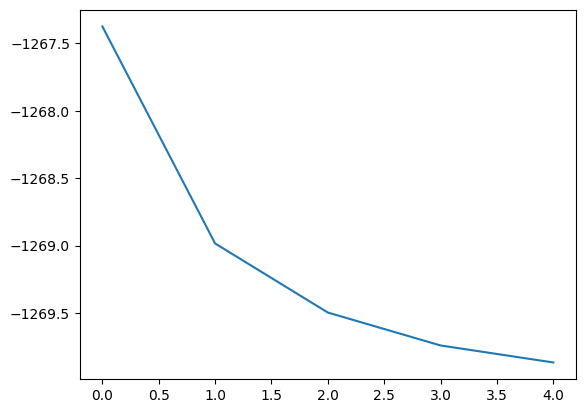

In [ ]:
import matplotlib.pyplot as plt
print(type(losses[0]))
plt.plot([loss.cpu().numpy() for loss in losses])
plt.show()

In [ ]:
import torch

# Assuming 'model' is your neural network
torch.save(model.state_dict(), 'model_weights.pth')
